# Analyzing Data with IBM Db2, SQL, and Python
## George Jordan
*Last update: February 6, 2021*


I am currently working through the 'IBM Data Science Professional Certificate' through Coursera. The certificate is a nine-course suite, with the fifth course being 'Databases and SQL for Data Science' and the sixth course being 'Data Analysis with Python'. I have recently completed these courses and will use this project to demonstrate my skills in these tools.

First, I will provide a brief overview of the queries that I wrote to fulfill the requirements of the assignment (which scored 100%). Then, I will visually display the data by comparing variables via scatterplot. I will use regression analysis to describe the relationships between variables. In doing so, I hope to provide interpretation that might otherwise not be obvious by simply viewing the data within the databases.

I believe that data does not speak for itself and requires a storyteller to communicate findings so that stakeholders can make informed decisions with the data. I firmly believe that this work is a waste of time if teams cannot use the work either for lack of interpretation or techincal knowledge. I hope that I can be that bridge to connect the data to those otherwise unable to use it.

In this project, I used three separate data sets to gain insight into Chicago's neighborhoods and schools. The data is made available through the city of Chicago's public data portal. For the scope of the project, the crime data has been truncated to around five hundred rows, as opposed to the original which contained around 6.5 million rows.

1.  <a href="https://data.cityofchicago.org/Health-Human-Services/Census-Data-Selected-socioeconomic-indicators-in-C/kn9c-c2s2">Socioeconomic Indicators in Chicago</a>
2.  <a href="https://data.cityofchicago.org/Education/Chicago-Public-Schools-Progress-Report-Cards-2011-/9xs2-f89t">Chicago Public Schools</a>
3.  <a href="https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2">Chicago Crime Data</a>

### Preparation

In [1]:
%load_ext sql

I connected to Db2 by instantiating an API token which allowed me to run all of my queries through a Jupyter notebook. For the sake of streamlining the project, doing this project through the Jupyter notebooks on Watson Labs allows for all of the IBM technologies to come packaged without having to reinstall each time I run the notebook.

In [2]:
%sql ibm_db_sa://tjk69312:mkjv%402qs5xgnc01k@dashdb-txn-sbox-yp-dal09-12.services.dal.bluemix.net:50000/BLUDB

'Connected: tjk69312@BLUDB'

In Db2, I have uploaded the .csv values of all three data setsinto the database.

In [3]:
# Verifying the connection was established with a simple query
%sql select count(*) from CHICAGO_CRIME_DATA

 * ibm_db_sa://tjk69312:***@dashdb-txn-sbox-yp-dal09-12.services.dal.bluemix.net:50000/BLUDB
Done.


1
533


### Sample Queries

In the next few cells, I will demonstrate some of the queries that I wrote in order to fulfill the requests for the assignment.

##### List the top 5 Community Areas by average College Enrollment [number of students]

In [4]:
%sql select COMMUNITY_AREA_NAME, avg(COLLEGE_ENROLLMENT) \
as AVERAGE_COLLEGE_ENROLLMENT \
from CHICAGO_PUBLIC_SCHOOLS \
group by COMMUNITY_AREA_NAME \
order by avg(COLLEGE_ENROLLMENT) desc limit 5

 * ibm_db_sa://tjk69312:***@dashdb-txn-sbox-yp-dal09-12.services.dal.bluemix.net:50000/BLUDB
Done.


community_area_name,average_college_enrollment
ARCHER HEIGHTS,2411.500000
MONTCLARE,1317.000000
WEST ELSDON,1233.333333
BRIGHTON PARK,1205.875000
BELMONT CRAGIN,1198.833333


##### Use a sub-query to determine which Community Area has the least value for school Safety Score?

In [5]:
%sql select COMMUNITY_AREA_NUMBER, COMMUNITY_AREA_NAME, SAFETY_SCORE \
from CHICAGO_PUBLIC_SCHOOLS \
where SAFETY_SCORE = (select min(SAFETY_SCORE) from CHICAGO_PUBLIC_SCHOOLS)

 * ibm_db_sa://tjk69312:***@dashdb-txn-sbox-yp-dal09-12.services.dal.bluemix.net:50000/BLUDB
Done.


community_area_number,community_area_name,safety_score
40,WASHINGTON PARK,1


##### Which schools in Community Areas 10 to 15 are healthy school certified?

In [6]:
%sql select NAME_OF_SCHOOL, COMMUNITY_AREA_NUMBER from CHICAGO_PUBLIC_SCHOOLS \
where COMMUNITY_AREA_NUMBER between 10 and 15 \
and HEALTHY_SCHOOL_CERTIFIED = 'Yes'

 * ibm_db_sa://tjk69312:***@dashdb-txn-sbox-yp-dal09-12.services.dal.bluemix.net:50000/BLUDB
Done.


name_of_school,community_area_number
Rufus M Hitch Elementary School,10


### Using Pandas Dataframes

In [7]:
# Run matplotlib to graph some of the schools on scatter plot
# Centered around Community_area, 77 different neighborhoods
# From CHICAGO_PUBLIC_SCHOOLS: Safety_Score, Rate_of_Misconduct, College_Enrollment_rate
# From CENSUS_DATA: Percent_of_housing_crowded, Perent_of_households_below_poverty, per_capita_income, hardship_index
# From CHICAGO_CRIME_DATA: Community

I will use the Pandas library to organize the data within the notebook environment. For the visualization of the data, I will be using the Python libraries Matplotlib, Numpy, and Seaborn. Scikit-Learn will be used to form predictive regression curves based on the data.

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression
%matplotlib inline

Then I created an localized instance of the data within the notebook for each data set.

In [9]:
CENSUS_DATA_local = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DB0201EN-SkillsNetwork/labs/FinalModule_Coursera/data/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012-v2.csv')

In [10]:
CHICAGO_PUBLIC_SCHOOLS_local = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DB0201EN-SkillsNetwork/labs/FinalModule_Coursera/data/Chicago_Public_Schools_-_Progress_Report_Cards__2011-2012-v3.csv')

In [11]:
CHICAGO_CRIME_DATA_local = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DB0201EN-SkillsNetwork/labs/FinalModule_Coursera/data/Chicago_Crime_Data-v2.csv')

To normalize the column names, I used string methods. Making the columns more uniform allows for less headaches down the road. Also, lowercase columns are easier on my eyes.

In [12]:
CENSUS_DATA_local.columns = CENSUS_DATA_local.columns.str.replace(" ", "_")
CENSUS_DATA_local.columns = CENSUS_DATA_local.columns.str.lower()
CHICAGO_PUBLIC_SCHOOLS_local.columns = CHICAGO_PUBLIC_SCHOOLS_local.columns.str.replace(" ", "_")
CHICAGO_PUBLIC_SCHOOLS_local.columns = CHICAGO_PUBLIC_SCHOOLS_local.columns.str.replace("%", "")
CHICAGO_PUBLIC_SCHOOLS_local.columns = CHICAGO_PUBLIC_SCHOOLS_local.columns.str.replace(",", "")
CHICAGO_PUBLIC_SCHOOLS_local.columns = CHICAGO_PUBLIC_SCHOOLS_local.columns.str.lower()
CHICAGO_CRIME_DATA_local.columns = CHICAGO_CRIME_DATA_local.columns.str.replace(" ", "_")
CHICAGO_CRIME_DATA_local.columns = CHICAGO_CRIME_DATA_local.columns.str.lower()

To simplify the code moving forward, I decided to shorten the names when creating Pandas dataframes.

In [13]:
df1 = pd.DataFrame(data=CENSUS_DATA_local)
df2 = pd.DataFrame(data=CHICAGO_PUBLIC_SCHOOLS_local)
df3 = pd.DataFrame(data=CHICAGO_CRIME_DATA_local)

Now that the dataframes are prepared and more easily accessed through localized instances within Pandas dataframes, listing out the column names here will allow comparisons across separate data frames.

In [14]:
print("Census Data (df1) Columns")
print(df1.columns.tolist())

Census Data (df1) Columns
['community_area_number', 'community_area_name', 'percent_of_housing_crowded', 'percent_households_below_poverty', 'percent_aged_16+_unemployed', 'percent_aged_25+_without_high_school_diploma', 'percent_aged_under_18_or_over_64', 'per_capita_income_', 'hardship_index']


In [15]:
print("Chicago Public Schools (df2) Columns")
print(df2.columns.tolist())

Chicago Public Schools (df2) Columns
['school_id', 'name_of_school', 'elementary_middle_or_high_school', 'street_address', 'city', 'state', 'zip_code', 'phone_number', 'link_', 'network_manager', 'collaborative_name', 'adequate_yearly_progress_made?_', 'track_schedule', 'cps_performance_policy_status', 'cps_performance_policy_level', 'healthy_school_certified', 'safety_icon_', 'safety_score', 'family_involvement_icon', 'family_involvement_score', 'environment_icon_', 'environment_score', 'instruction_icon_', 'instruction_score', 'leaders_icon_', 'leaders_score_', 'teachers_icon_', 'teachers_score', 'parent_engagement_icon_', 'parent_engagement_score', 'parent_environment_icon', 'parent_environment_score', 'average_student_attendance', 'rate_of_misconducts_(per_100_students)_', 'average_teacher_attendance', 'individualized_education_program_compliance_rate_', 'pk-2_literacy_', 'pk-2_math_', 'gr3-5_grade_level_math_', 'gr3-5_grade_level_read__', 'gr3-5_keep_pace_read_', 'gr3-5_keep_pace_

In [16]:
print("Chicago Crime Data (df3) Columns")
print(df3.columns.tolist())

Chicago Crime Data (df3) Columns
['id', 'case_number', 'date', 'block', 'iucr', 'primary_type', 'description', 'location_description', 'arrest', 'domestic', 'beat', 'district', 'ward', 'community_area_number', 'fbicode', 'x_coordinate', 'y_coordinate', 'year', 'updatedon', 'latitude', 'longitude', 'location']


I only wish to look at a subset of the columns from all of the dataframes, so I will used the .copy() method to create abridged dataframes.

In [74]:
census = df1[['community_area_number', 'community_area_name', 'percent_of_housing_crowded', 'percent_households_below_poverty', 'per_capita_income_', 'hardship_index']].copy()
census = census.set_index('community_area_number')
census = census.drop(census.tail(1).index) #Removes the last row which was an average of all the community areas
census

,community_area_name,percent_of_housing_crowded,percent_households_below_poverty,per_capita_income_,hardship_index
community_area_number,,,,,
1.0,Rogers Park,7.7,23.6,23939,39.0
2.0,West Ridge,7.8,17.2,23040,46.0
3.0,Uptown,3.8,24.0,35787,20.0
4.0,Lincoln Square,3.4,10.9,37524,17.0
5.0,North Center,0.3,7.5,57123,6.0
...,...,...,...,...,...
73.0,Washington Height,1.1,16.9,19713,48.0
74.0,Mount Greenwood,1.0,3.4,34381,16.0
75.0,Morgan Park,0.8,13.2,27149,30.0


In [75]:
schools = df2[['name_of_school', 'community_area_number', 'community_area_name', 'police_district', 'college_enrollment', 'safety_score', 'family_involvement_score']].copy()
schools

,name_of_school,community_area_number,community_area_name,police_district,college_enrollment,safety_score,family_involvement_score
0,Abraham Lincoln Elementary School,7,LINCOLN PARK,18,813,99.0,99
1,Adam Clayton Powell Paideia Community Academy ...,43,SOUTH SHORE,4,521,54.0,66
2,Adlai E Stevenson Elementary School,70,ASHBURN,8,1324,61.0,NDA
3,Agustin Lara Elementary Academy,61,NEW CITY,9,556,56.0,44
4,Air Force Academy High School,34,ARMOUR SQUARE,9,302,49.0,60
...,...,...,...,...,...,...,...
561,William T Sherman Elementary School,61,NEW CITY,9,462,32.0,NDA
562,William W Carter Elementary School,40,WASHINGTON PARK,2,371,13.0,49
563,Wolfgang A Mozart Elementary School,22,LOGAN SQUARE,25,748,41.0,NDA
564,Woodlawn Community Elementary School,42,WOODLAWN,3,238,70.0,NDA


In [76]:
crime = df3[['id', 'case_number', 'primary_type', 'community_area_number', 'district']].copy()
crime = crime.set_index('community_area_number')
crime = crime.groupby('community_area_number').size().sort_values(ascending=False).reset_index(name='Sum of Crime Reports')
crime

,community_area_number,Sum of Crime Reports
0,25.0,43
1,23.0,22
2,68.0,21
3,29.0,16
4,28.0,16
...,...,...
65,12.0,1
66,55.0,1
67,47.0,1
68,75.0,1


### Regression and Correlation Analysis

Now I will use some plotting tools to see if there is a correlation between certain features of these community areas.

<AxesSubplot:xlabel='per_capita_income_', ylabel='hardship_index'>

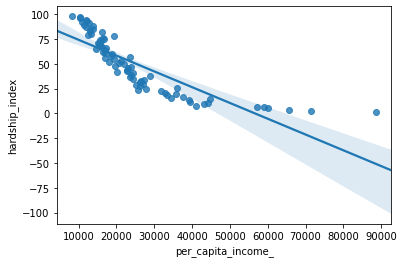

In [77]:
sns.regplot(x = "per_capita_income_", y = "hardship_index", data = census)

It's a pretty clear relationship shown that as per capita income increases, measure of hardship decreases. We can also use the "corr" method in pandas to see how correlated the other measures are to the hardship index.

In [78]:
census.corr()['hardship_index'].sort_values()

per_capita_income_                 -0.849167
percent_of_housing_crowded          0.649574
percent_households_below_poverty    0.803267
hardship_index                      1.000000
Name: hardship_index, dtype: float64

In [79]:
schools.corr()['safety_score'].sort_values()

community_area_number   -0.375084
college_enrollment       0.089813
police_district          0.306982
safety_score             1.000000
Name: safety_score, dtype: float64

The census data seems to have the most correlative data for the dependent variable 'hardship_index', so it is the best candidate to construct a predictive model. Using Scikit-Learn, I will split the data into two sets. The training set will be used to train the model and the test set will be used to test the accuracy of the model. I will set the test set at 15% of the total data samples so that 85% will go towards training the model.

In [83]:
from sklearn.model_selection import train_test_split

In [84]:
features =['percent_of_housing_crowded', 'percent_households_below_poverty', 'per_capita_income_']    
X = census[features]
Y = census['hardship_index']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=1)


print("number of test samples:", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples: 12
number of training samples: 65


In [85]:
from sklearn.linear_model import LinearRegression

In [89]:
censusReg = LinearRegression()
censusReg.fit(x_train, y_train)
censusReg.score(x_test, y_test)

0.9640365972322784

Our model has fit the test data with an R-squared value of .964, which means our model has predicted the variability of the test data with an accuracy of roughly 96.4%.

AttributeError: 'LinearRegression' object has no attribute 'show'